In [1]:
import pandas as pd 
from sys import path
path.append('..')
from solardatatools import standardize_time_axis, make_2d, plot_2d, load_pvo_data
import boto3
from solardataretrieval import utilities 
from solardataretrieval.retrieval import Retrieval
from functools import partial
from solardatatools.clear_day_detection import filter_for_sparsity
from solardatatools import find_clear_days


In [2]:
#set variables here: 
#choose how many sites you want in your data pipeline
number_of_sites = 10
number_of_days = 20
quantile_percent = 0.95
#set filter thresholds and time sample (if 5 min: day_samples = 288)
sparsity_th = 0.3
quality_th = 0.7
day_samples = 288

In [9]:
y = Retrieval()

In [10]:
sparcity_filter = partial(filter_for_sparsity, solver='MOSEK')
y.add_daily_filter(sparcity_filter)
y.add_daily_filter(find_clear_days)

[functools.partial(<function filter_for_sparsity at 0x10d40ab70>, solver='MOSEK'),
 <function solardatatools.clear_day_detection.find_clear_days(data, th=0.1, boolean_out=True)>]

In [11]:
#y.construct_standard_site_filters()

In [12]:
y.add_site_filter(y.summary_df['overall_quality'] > quality_th)

[0        True
 1        True
 2        True
 3        True
 4        True
 5        True
 6        True
 7        True
 8        True
 9       False
 10       True
 11       True
 12       True
 13       True
 14       True
 15       True
 16       True
 17       True
 18       True
 19       True
 20       True
 21       True
 22       True
 23       True
 24       True
 25       True
 26       True
 27       True
 28       True
 29       True
         ...  
 1913    False
 1914    False
 1915    False
 1916    False
 1917    False
 1918    False
 1919    False
 1920     True
 1921    False
 1922    False
 1923     True
 1924    False
 1925    False
 1926     True
 1927     True
 1928     True
 1929     True
 1930     True
 1931     True
 1932     True
 1933     True
 1934     True
 1935     True
 1936     True
 1937     True
 1938     True
 1939     True
 1940     True
 1941     True
 1942     True
 Name: overall_quality, Length: 1943, dtype: bool]

In [13]:
df_data_input, df_meta_data = y.data_retrieval(number_of_sites, number_of_days, quantile_percent)

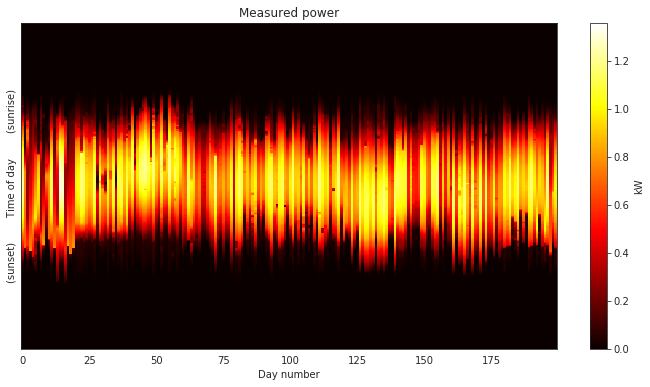

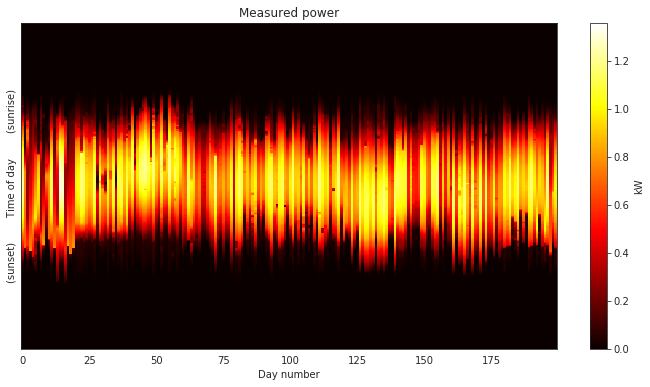

In [14]:
plot_2d(df_data_input)